# LIBERO 数据集可视化与 Grounding DINO 标注效果

本 notebook 用于：
1. 可视化 LIBERO RLDS 数据集中的图像和语言指令
2. 使用预训练 Grounding DINO 进行物体检测
3. 展示检测结果和伪标签效果


## 1. 导入依赖


In [ ]:
import os
import sys

# 设置 Hugging Face 镜像（必须在导入 transformers 之前）
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

# 设置项目根目录 - 查找包含 data 目录的父目录
def find_project_root():
    """向上查找包含 data 目录的项目根目录"""
    # 首先尝试从当前文件位置推断
    current = Path(__file__).resolve().parent if '__file__' in dir() else Path.cwd()
    
    # 向上查找，最多查找 5 级
    for _ in range(5):
        if (current / "data").exists() or (current / "vla-scripts").exists():
            return current
        current = current.parent
    
    # 如果找不到，尝试常见路径
    common_paths = [
        Path("D:/files/VLA-Adapter"),
        Path.cwd(),
        Path("../../").resolve(),
    ]
    for p in common_paths:
        if (p / "data").exists():
            return p
    
    return Path.cwd()

PROJECT_ROOT = find_project_root()
os.chdir(PROJECT_ROOT)
print(f"Working directory: {os.getcwd()}")

# 验证数据目录存在
if (PROJECT_ROOT / "data" / "modified_libero_rlds").exists():
    print("✓ 数据目录存在")
else:
    print("⚠ 数据目录未找到，请检查路径")

# 导入 tensorflow 和 tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# 导入 HuggingFace transformers
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# 设置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("✓ 依赖导入成功！")


Working directory: d:\files\VLA-Adapter
✓ 数据目录存在
✓ 依赖导入成功！


## 2. 加载 LIBERO 数据集


In [ ]:
# 数据集路径配置
DATA_DIR = Path("data/modified_libero_rlds")

# 可用的数据集子集
SUBSETS = [
    "libero_spatial_no_noops",
    "libero_object_no_noops", 
    "libero_goal_no_noops",
    "libero_10_no_noops"
]

# 检查哪些子集已下载
available_subsets = []
for subset in SUBSETS:
    subset_path = DATA_DIR / subset
    if subset_path.exists():
        available_subsets.append(subset)
        print(f"✓ {subset}")
    else:
        print(f"✗ {subset} (未下载)")

print(f"\n可用数据集: {len(available_subsets)}/{len(SUBSETS)}")


✓ libero_spatial_no_noops
✓ libero_object_no_noops
✓ libero_goal_no_noops
✓ libero_10_no_noops

可用数据集: 4/4


In [ ]:
# 选择一个子集来加载 (优先选择 libero_10_no_noops，数据更完整)
if not available_subsets:
    print("⚠ 没有找到任何已下载的数据集！")
    print(f"  当前工作目录: {os.getcwd()}")
    print(f"  数据目录路径: {DATA_DIR.resolve()}")
    print(f"  数据目录存在: {DATA_DIR.exists()}")
    if DATA_DIR.exists():
        print(f"  数据目录内容: {list(DATA_DIR.iterdir())}")
    raise RuntimeError("请先下载数据集，或检查工作目录设置是否正确")

SELECTED_SUBSET = "libero_10_no_noops" if "libero_10_no_noops" in available_subsets else available_subsets[0]
print(f"加载数据集: {SELECTED_SUBSET}")

# 数据集路径
dataset_path = DATA_DIR / SELECTED_SUBSET

# 检查目录结构 - RLDS 格式的数据在 1.0.0 子目录中
version_dir = dataset_path / "1.0.0"
if version_dir.exists():
    print(f"  发现版本目录: {version_dir}")
    # 检查必需文件
    dataset_info_path = version_dir / "dataset_info.json"
    if dataset_info_path.exists():
        print(f"  ✓ dataset_info.json 存在")
    else:
        print(f"  ✗ dataset_info.json 不存在")
else:
    print(f"  ✗ 版本目录不存在: {version_dir}")
    version_dir = dataset_path  # fallback

# 使用 tensorflow_datasets 加载 - 注意：需要指向包含 dataset_info.json 的目录
try:
    # 尝试从版本目录加载（包含 dataset_info.json）
    builder = tfds.builder_from_directory(str(version_dir))
    ds = builder.as_dataset(split='train')
    
    # 获取数据集信息
    print(f"\n数据集信息:")
    print(f"  路径: {version_dir}")
    print(f"  特征: {builder.info.features}")
    use_raw_format = False
except Exception as e:
    print(f"\ntfds 加载失败: {e}")
    print("\n尝试直接读取 TFRecord 文件...")
    
    # 备用方案：直接读取 TFRecord
    tfrecord_files = list(version_dir.glob("*.tfrecord-*"))
    print(f"找到 {len(tfrecord_files)} 个 TFRecord 文件")
    
    if tfrecord_files:
        # 使用原始 TFRecord 读取
        raw_dataset = tf.data.TFRecordDataset([str(f) for f in tfrecord_files[:1]])
        print("✓ TFRecord 文件可以读取")
        ds = None  # 标记需要使用备用方案
        use_raw_format = True
    else:
        print("✗ 未找到 TFRecord 文件")
        ds = None
        use_raw_format = False


加载数据集: libero_10_no_noops
  发现版本目录: data\modified_libero_rlds\libero_10_no_noops\1.0.0
  ✓ dataset_info.json 存在

数据集信息:
  路径: data\modified_libero_rlds\libero_10_no_noops\1.0.0
  特征: FeaturesDict({
    'episode_metadata': FeaturesDict({
        'file_path': Text(shape=(), dtype=string),
    }),
    'steps': Dataset({
        'action': Tensor(shape=(7,), dtype=float32, description=Robot EEF action.),
        'discount': Scalar(shape=(), dtype=float32, description=Discount if provided, default to 1.),
        'is_first': Scalar(shape=(), dtype=bool, description=True on first step of the episode.),
        'is_last': Scalar(shape=(), dtype=bool, description=True on last step of the episode.),
        'is_terminal': Scalar(shape=(), dtype=bool, description=True on last step of the episode if it is a terminal step, True for demos.),
        'language_instruction': Text(shape=(), dtype=string),
        'observation': FeaturesDict({
            'image': Image(shape=(256, 256, 3), dtype=uint8,

In [ ]:
# 备用方案：直接使用 tf.data.TFRecordDataset 加载
# RLDS 数据使用 SequenceExample 格式，但数据存储在 context 中

def explore_tfrecord_structure(tfrecord_path, num_samples=1):
    """探测 TFRecord 文件的结构"""
    print(f"探测文件: {Path(tfrecord_path).name}")
    
    dataset = tf.data.TFRecordDataset(str(tfrecord_path))
    
    for raw_record in dataset.take(num_samples):
        # 尝试解析为 SequenceExample（RLDS 格式）
        try:
            seq_example = tf.train.SequenceExample()
            seq_example.ParseFromString(raw_record.numpy())
            context_keys = list(seq_example.context.feature.keys())
            feature_list_keys = list(seq_example.feature_lists.feature_list.keys())
            
            # 判断数据在 context 还是 feature_lists 中
            if context_keys and not feature_list_keys:
                print("  格式: SequenceExample (数据在 context 中)")
                print(f"  Context 特征: {context_keys[:5]}...")
                return "context", seq_example
            elif feature_list_keys:
                print("  格式: SequenceExample (数据在 feature_lists 中)")
                print(f"  FeatureList 特征: {feature_list_keys[:5]}...")
                return "feature_lists", seq_example
        except:
            pass
        
        # 尝试解析为 Example
        try:
            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())
            print("  格式: tf.train.Example")
            features = list(example.features.feature.keys())[:5]
            print(f"  特征: {features}...")
            return "example", example
        except:
            pass
    
    print("  无法解析 TFRecord 格式")
    return None, None


def parse_rlds_context_format(serialized):
    """解析 RLDS TFRecord - 数据存储在 context 中的格式"""
    seq_example = tf.train.SequenceExample()
    seq_example.ParseFromString(serialized.numpy())
    
    context = seq_example.context.feature
    episode = {}
    
    # 提取图像序列（存储为 bytes_list）
    if 'steps/observation/image' in context:
        images = list(context['steps/observation/image'].bytes_list.value)
        episode['images'] = images
    
    # 提取 wrist 图像
    if 'steps/observation/wrist_image' in context:
        wrist_images = list(context['steps/observation/wrist_image'].bytes_list.value)
        episode['wrist_images'] = wrist_images
    
    # 提取语言指令
    if 'steps/language_instruction' in context:
        instructions = [s.decode('utf-8') for s in context['steps/language_instruction'].bytes_list.value]
        episode['language_instruction'] = instructions
    
    # 提取 action
    if 'steps/action' in context:
        actions = list(context['steps/action'].float_list.value)
        episode['action'] = actions
    
    # 提取 episode 元数据
    if 'episode_metadata/file_path' in context:
        file_path = context['episode_metadata/file_path'].bytes_list.value
        if file_path:
            episode['file_path'] = file_path[0].decode('utf-8')
    
    return episode


def load_episodes_from_tfrecord(version_dir, num_episodes=5):
    """从 TFRecord 文件加载 episodes"""
    # 获取 tfrecord 文件
    tfrecord_files = sorted(list(version_dir.glob("*.tfrecord-*")))
    
    if not tfrecord_files:
        print("未找到 tfrecord 文件")
        return []
    
    # 只使用第一个文件
    tfrecord_file = tfrecord_files[0]
    print(f"使用文件: {tfrecord_file.name}")
    
    # 首先探测格式
    format_type, sample = explore_tfrecord_structure(tfrecord_file)
    
    if format_type not in ["context", "feature_lists", "example"]:
        print(f"不支持的格式: {format_type}")
        return []
    
    # 加载 episodes
    dataset = tf.data.TFRecordDataset(str(tfrecord_file))
    episodes = []
    
    print(f"\n加载 episodes...")
    for i, raw_record in enumerate(dataset.take(num_episodes)):
        try:
            episode = parse_rlds_context_format(raw_record)
            num_frames = len(episode.get('images', []))
            instructions = episode.get('language_instruction', ['Unknown'])
            instruction = instructions[0][:50] if instructions else "Unknown"
            episodes.append(episode)
            print(f"  ✓ Episode {i}: {num_frames} frames - \"{instruction}...\"")
            
        except Exception as e:
            print(f"  ✗ Episode {i} 解析失败: {str(e)[:100]}")
            continue
    
    return episodes


print("✓ 备用加载函数已定义")


✓ 备用加载函数已定义


## 3. 可视化 LIBERO 数据集样本


In [ ]:
def visualize_episode_tfds(episode, num_frames=8, figsize=(16, 8)):
    """可视化一个 episode 的帧序列 (tfds 格式)"""
    steps = list(episode['steps'])
    total_frames = len(steps)
    
    # 获取语言指令
    lang_instruction = steps[0]['language_instruction'].numpy()
    if isinstance(lang_instruction, bytes):
        lang_instruction = lang_instruction.decode('utf-8')
    
    # 选择要显示的帧
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, num_frames // 2, figsize=figsize)
    axes = axes.flatten()
    
    fig.suptitle(f'Language Instruction: "{lang_instruction}"', fontsize=14, y=1.02)
    
    for i, idx in enumerate(indices):
        step = steps[idx]
        image = step['observation']['image'].numpy()
        axes[i].imshow(image)
        axes[i].set_title(f'Frame {idx}/{total_frames}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return lang_instruction, steps


def visualize_episode_raw(episode, num_frames=8, figsize=(16, 8)):
    """可视化一个 episode 的帧序列 (原始 TFRecord 格式)"""
    # 获取图像序列 (列表形式，每个元素是 JPEG 编码的字节)
    images = episode['images']
    total_frames = len(images)
    
    # 获取语言指令
    lang_instructions = episode.get('language_instruction', ['Unknown'])
    lang_instruction = lang_instructions[0] if lang_instructions else "Unknown"
    
    # 选择要显示的帧
    indices = np.linspace(0, total_frames - 1, min(num_frames, total_frames), dtype=int)
    
    n_cols = min(num_frames, 4)
    n_rows = (len(indices) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1)
    elif n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    axes = axes.flatten()
    
    fig.suptitle(f'Language Instruction: "{lang_instruction}"', fontsize=14, y=1.02)
    
    for i, idx in enumerate(indices):
        # 解码 JPEG 图像
        img_bytes = images[idx]
        img = tf.io.decode_jpeg(img_bytes, channels=3).numpy()
        
        axes[i].imshow(img)
        axes[i].set_title(f'Frame {idx}/{total_frames}')
        axes[i].axis('off')
    
    # 隐藏多余的子图
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return lang_instruction, images


# 加载 episodes
print("=" * 50)
print("正在加载 episodes...")
print("=" * 50)

if ds is not None:
    # 使用 tfds 方式
    print("使用 tfds.builder_from_directory 加载...")
    episodes = list(ds.take(3))
    use_raw_format = False
else:
    # 使用原始 TFRecord 方式（SequenceExample 格式）
    print("使用原始 TFRecord 加载...")
    episodes = load_episodes_from_tfrecord(version_dir, num_episodes=3)
    use_raw_format = True

print(f"\n{'=' * 50}")
print(f"加载完成！共 {len(episodes)} 个 episodes")
print(f"{'=' * 50}")


正在加载 episodes...
使用 tfds.builder_from_directory 加载...

加载完成！共 3 个 episodes


Episode 1:


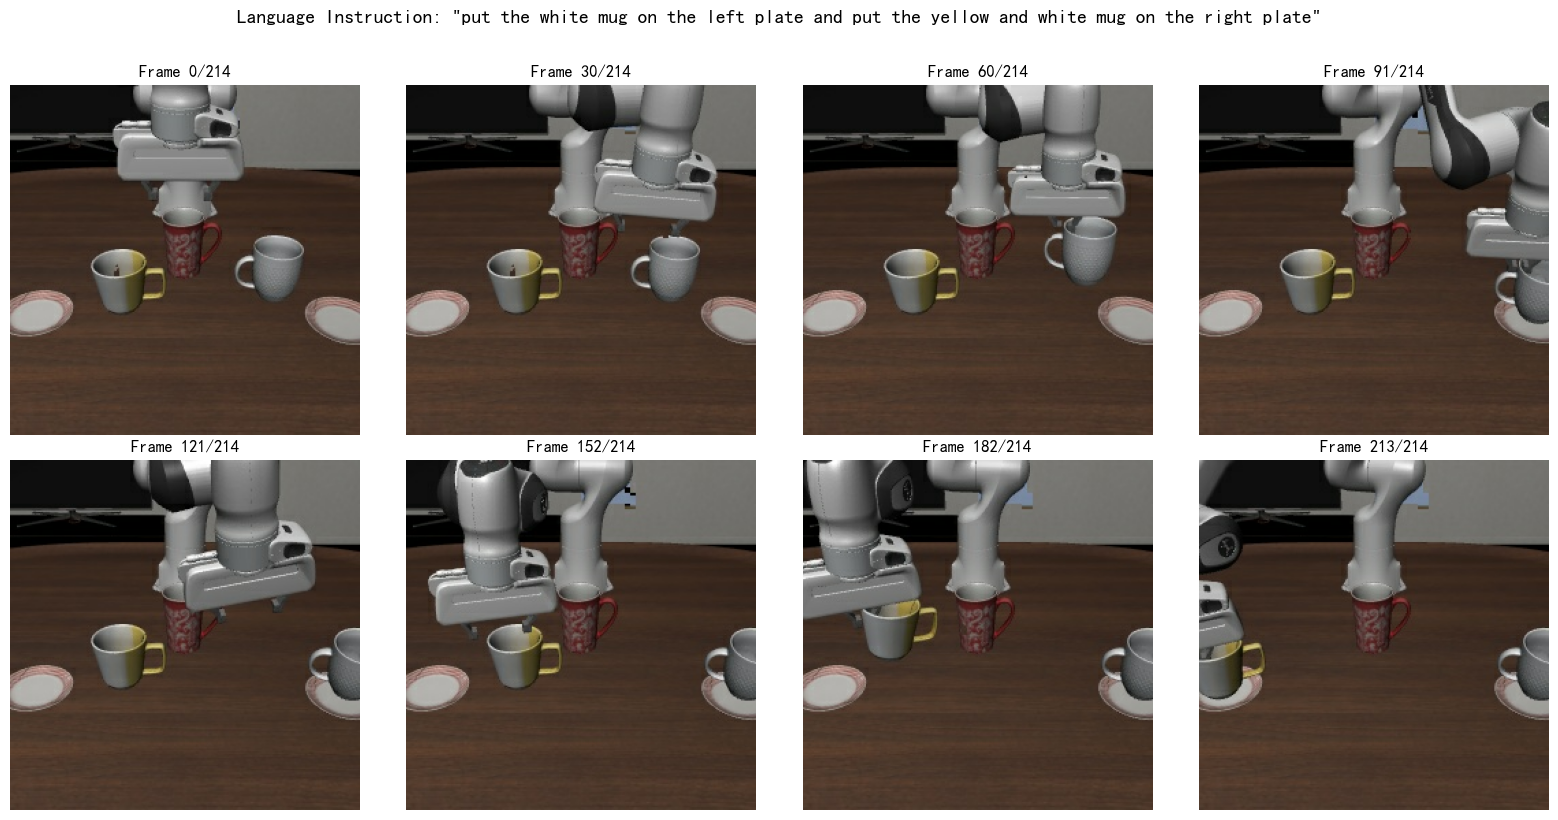

In [ ]:
# 可视化第一个 episode
if len(episodes) > 0:
    print("Episode 1:")
    if use_raw_format:
        lang1, images1 = visualize_episode_raw(episodes[0])
    else:
        lang1, steps1 = visualize_episode_tfds(episodes[0])


Episode 2:


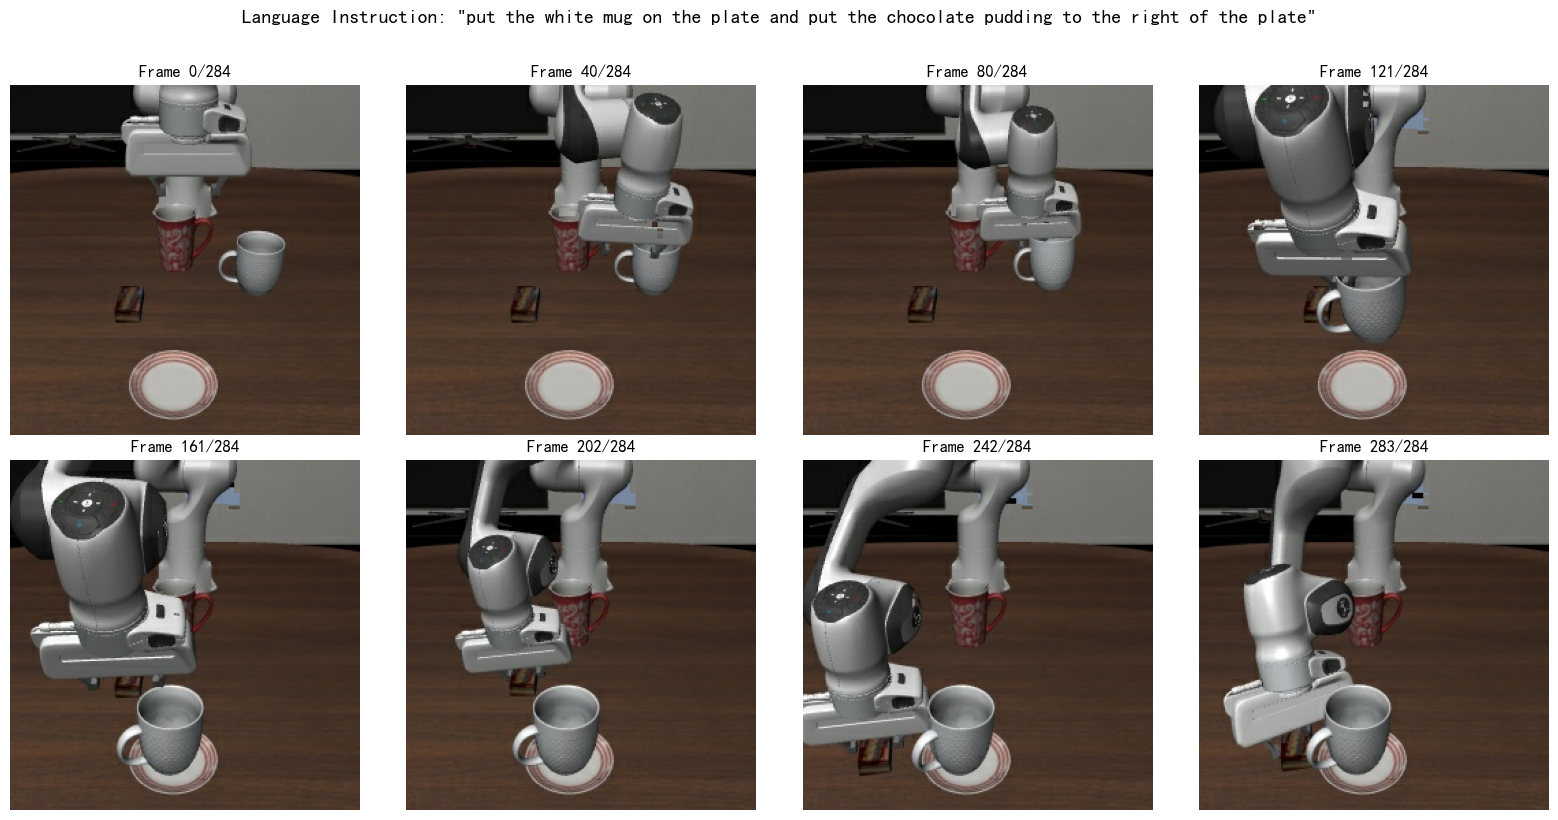

In [ ]:
# 可视化第二个 episode
if len(episodes) > 1:
    print("Episode 2:")
    if use_raw_format:
        lang2, images2 = visualize_episode_raw(episodes[1])
    else:
        lang2, steps2 = visualize_episode_tfds(episodes[1])


## 4. 加载 Grounding DINO 模型


In [13]:
# 加载 Grounding DINO 模型
MODEL_ID = "IDEA-Research/grounding-dino-tiny"

print(f"正在加载模型: {MODEL_ID}")
print("(首次加载会下载模型权重，可能需要几分钟...)")

processor = AutoProcessor.from_pretrained(MODEL_ID)
model = AutoModelForZeroShotObjectDetection.from_pretrained(MODEL_ID)

# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"✓ 模型加载成功！使用设备: {device}")


正在加载模型: IDEA-Research/grounding-dino-tiny
(首次加载会下载模型权重，可能需要几分钟...)
✓ 模型加载成功！使用设备: cuda


## 5. 使用 Grounding DINO 检测物体


In [ ]:
def extract_objects_from_instruction(instruction):
    """从语言指令中提取可能的物体名称"""
    instruction = instruction.lower()
    
    # 常见的 LIBERO 物体
    common_objects = [
        'cup', 'mug', 'bowl', 'plate', 'bottle', 'can',
        'box', 'container', 'drawer', 'cabinet', 'shelf',
        'handle', 'lid', 'door', 'button', 'switch',
        'pot', 'pan', 'kettle', 'microwave', 'stove',
        'fridge', 'refrigerator', 'sink', 'faucet',
        'table', 'counter', 'tray', 'basket',
        'block', 'cube', 'ball', 'toy',
        'robot arm', 'gripper'
    ]
    
    colors = ['red', 'blue', 'green', 'yellow', 'white', 'black', 'orange', 'purple', 'pink']
    
    found = []
    for obj in common_objects:
        if obj in instruction:
            # 检查是否有颜色修饰
            for color in colors:
                if f'{color} {obj}' in instruction:
                    found.append(f'{color} {obj}')
                    break
            else:
                found.append(obj)
    
    return list(set(found)) if found else ['object']


def detect_objects(image, text_prompt, box_threshold=0.25, text_threshold=0.25):
    """使用 Grounding DINO 检测物体"""
    # 确保 image 是 PIL Image
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # 处理输入
    inputs = processor(images=image, text=text_prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # 推理
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 后处理
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs["input_ids"],
        box_threshold=box_threshold,
        text_threshold=text_threshold,
        target_sizes=[image.size[::-1]]  # (height, width)
    )[0]
    
    return results


def visualize_detection(image, results, title="Detection Results"):
    """可视化检测结果"""
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"]
    
    # 颜色映射
    colors = plt.cm.rainbow(np.linspace(0, 1, len(boxes)))
    
    for box, score, label, color in zip(boxes, scores, labels, colors):
        x1, y1, x2, y2 = box
        
        # 绘制边界框
        rect = plt.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            fill=False, edgecolor=color, linewidth=2
        )
        ax.add_patch(rect)
        
        # 添加标签
        ax.text(
            x1, y1 - 5,
            f'{label}: {score:.2f}',
            color='white',
            fontsize=10,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.8)
        )
    
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return len(boxes)

print("✓ 检测函数定义完成！")


✓ 检测函数定义完成！


Source/Target 提取测试

指令: put the white mug on the left plate
  动作: put
  Source: ['white mug']
  Target: ['left plate']
  旧 Prompt: plate . white mug .
  新 Prompt: white mug . left plate .
------------------------------------------------------------

指令: put the white mug on the left plate and put the yellow and white mug on the right plate
  动作: put
  Source: ['white mug', 'yellow and white mug']
  Target: ['left plate', 'right plate']
  旧 Prompt: plate . white mug .
  新 Prompt: white mug . yellow and white mug . left plate . right plate .
------------------------------------------------------------

指令: pick up the red cup
  动作: pick up
  Source: ['red cup']
  Target: None
  旧 Prompt: red cup .
  新 Prompt: red cup .
------------------------------------------------------------

指令: open the drawer
  动作: open
  Source: ['drawer']
  Target: None
  旧 Prompt: drawer .
  新 Prompt: drawer .
------------------------------------------------------------

指令: turn on the stove
  动作: turn on
  So

修复后的 Source/Target 提取测试


📝 指令: put the yellow and white mug in microwave and close it
   期望: source=[yellow and white mug], target=[microwave]
   ────────────────────────────────
   Action: put
   Source: ['yellow and white mug']
   Target: ['microwave']
   Secondary: close it
   Prompt: yellow and white mug . microwave .

📝 指令: put the yellow and white mug on the left plate
   期望: source=[yellow and white mug], target=[left plate]
   ────────────────────────────────
   Action: put
   Source: ['yellow and white mug']
   Target: ['left plate']
   Secondary: None
   Prompt: yellow and white mug . left plate .

📝 指令: put the white mug on the left plate and put the yellow and white mug on the right plate
   期望: source=[white mug, yellow and white mug], target=[left plate, right plate]
   ────────────────────────────────
   Action: put
   Source: ['white mug', 'yellow and white mug']
   Target: ['left plate', 'right plate']
   Secondary: None
   Prompt: white mug . yellow and white mug . l

新旧 Prompt 检测效果对比

────────────────────────────────────────────────────────────
Episode 1
────────────────────────────────────────────────────────────


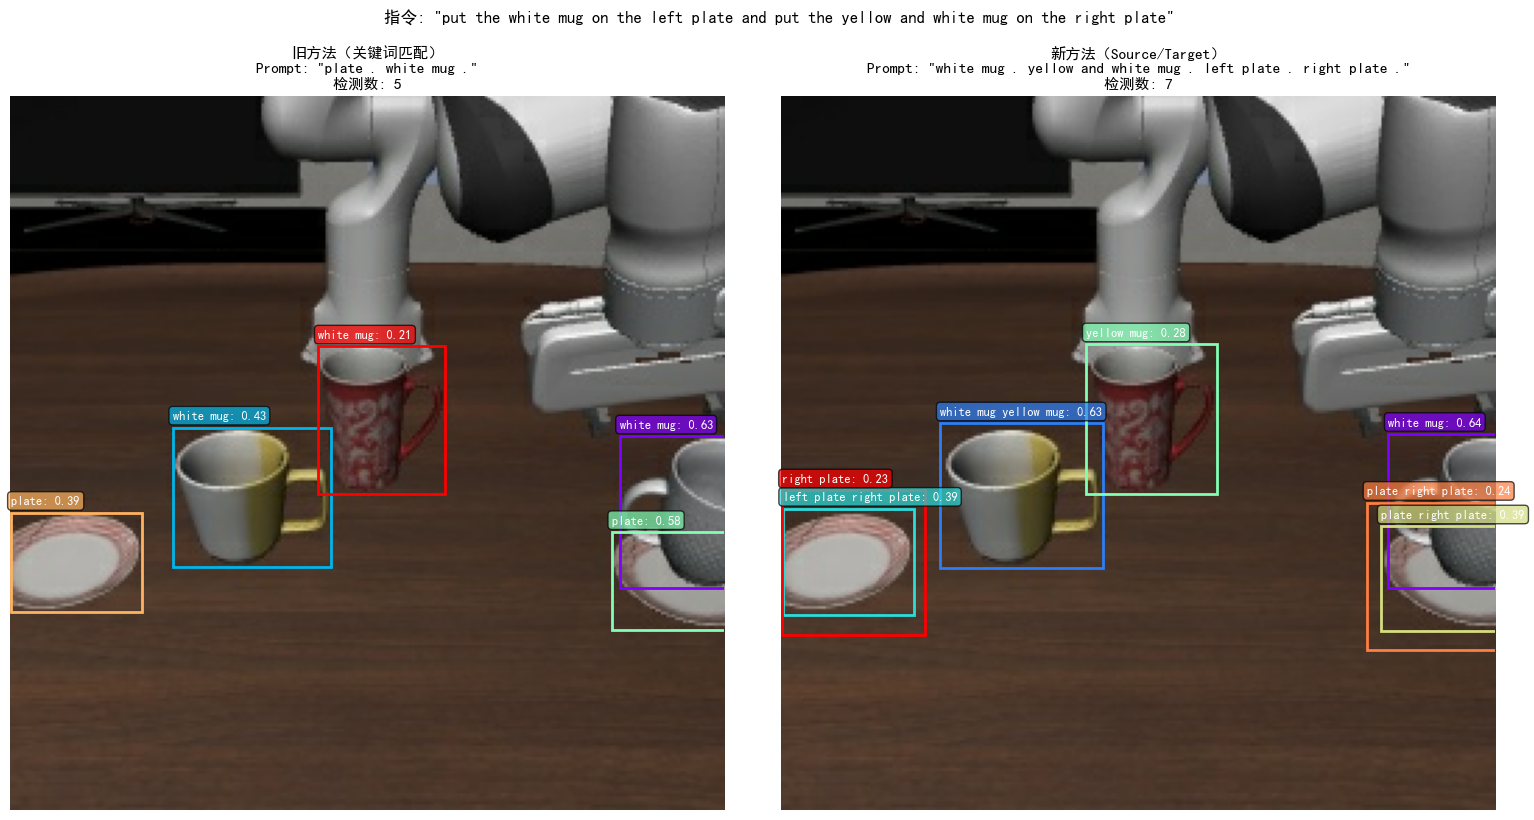

  旧方法: 5 个检测
  新方法: 7 个检测
  Source: ['white mug', 'yellow and white mug']
  Target: ['left plate', 'right plate']

────────────────────────────────────────────────────────────
Episode 2
────────────────────────────────────────────────────────────


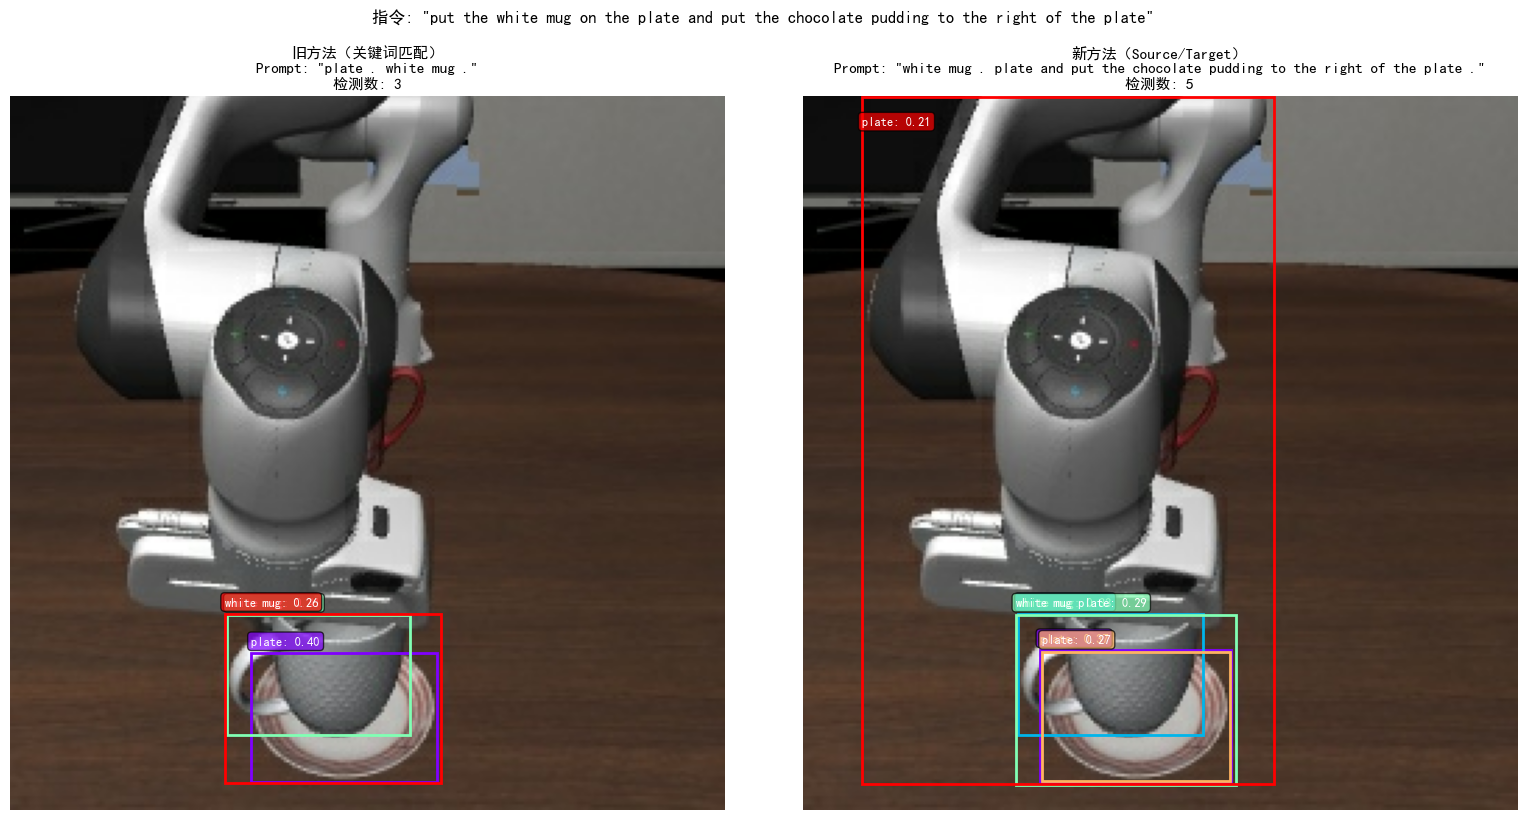

  旧方法: 3 个检测
  新方法: 5 个检测
  Source: ['white mug']
  Target: ['plate and put the chocolate pudding to the right of the plate']

────────────────────────────────────────────────────────────
Episode 3
────────────────────────────────────────────────────────────


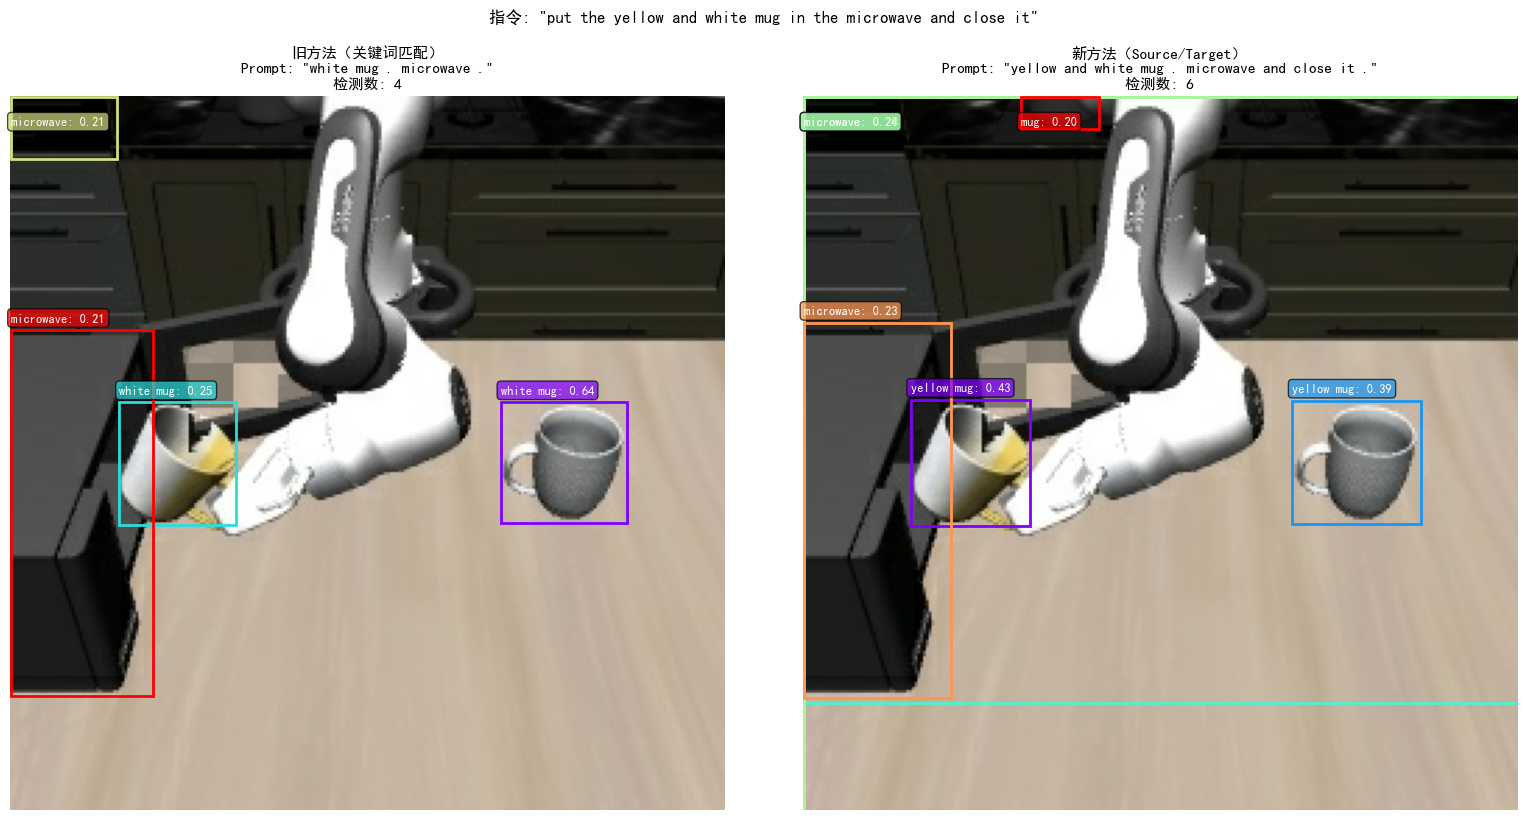

  旧方法: 4 个检测
  新方法: 6 个检测
  Source: ['yellow and white mug']
  Target: ['microwave and close it']

对比汇总
旧方法总检测数: 12
新方法总检测数: 18


语言指令: put the white mug on the left plate and put the yellow and white mug on the right plate
提取的物体: ['plate', 'white mug']
检测 prompt: plate . white mug .


d:\wu_work\anaconda3\envs\grounding_dino\lib\site-packages\transformers\models\grounding_dino\processing_grounding_dino.py:93: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


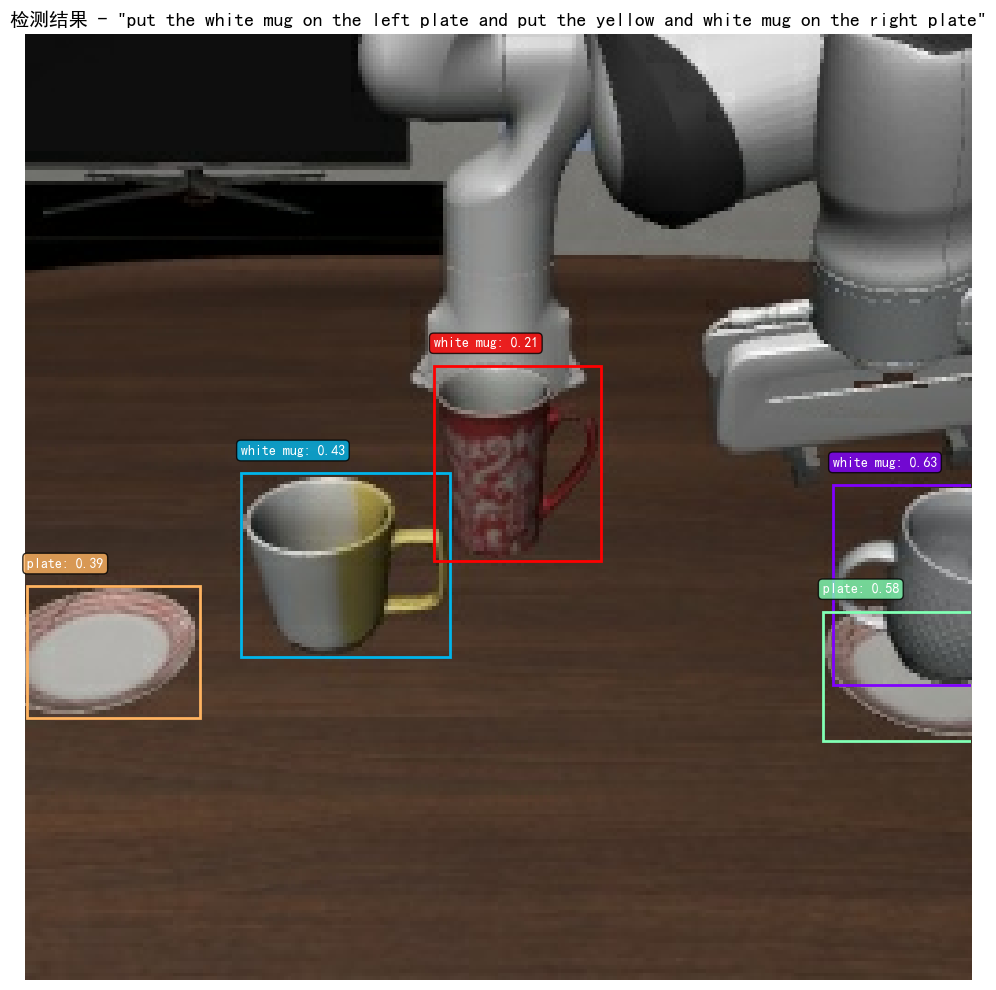

检测到 5 个物体


In [15]:
# 对第一个 episode 的一帧进行检测
if len(episodes) > 0:
    # 获取测试图像
    if use_raw_format:
        images = episodes[0]['images']  # 列表形式
        mid_idx = len(images) // 2
        test_image = tf.io.decode_jpeg(images[mid_idx], channels=3).numpy()
    else:
        mid_idx = len(steps1) // 2
        test_image = steps1[mid_idx]['observation']['image'].numpy()
    
    # 提取物体名称
    objects = extract_objects_from_instruction(lang1)
    text_prompt = " . ".join(objects) + " ."
    
    print(f"语言指令: {lang1}")
    print(f"提取的物体: {objects}")
    print(f"检测 prompt: {text_prompt}")
    
    # 运行检测
    results = detect_objects(test_image, text_prompt, box_threshold=0.2, text_threshold=0.2)
    
    # 可视化结果
    num_detections = visualize_detection(
        test_image, 
        results, 
        title=f'检测结果 - "{lang1}"'
    )
    print(f"检测到 {num_detections} 个物体")
else:
    print("没有加载到 episodes，请检查数据加载步骤")


## 6. 批量检测多帧效果对比


Episode 1 检测序列:


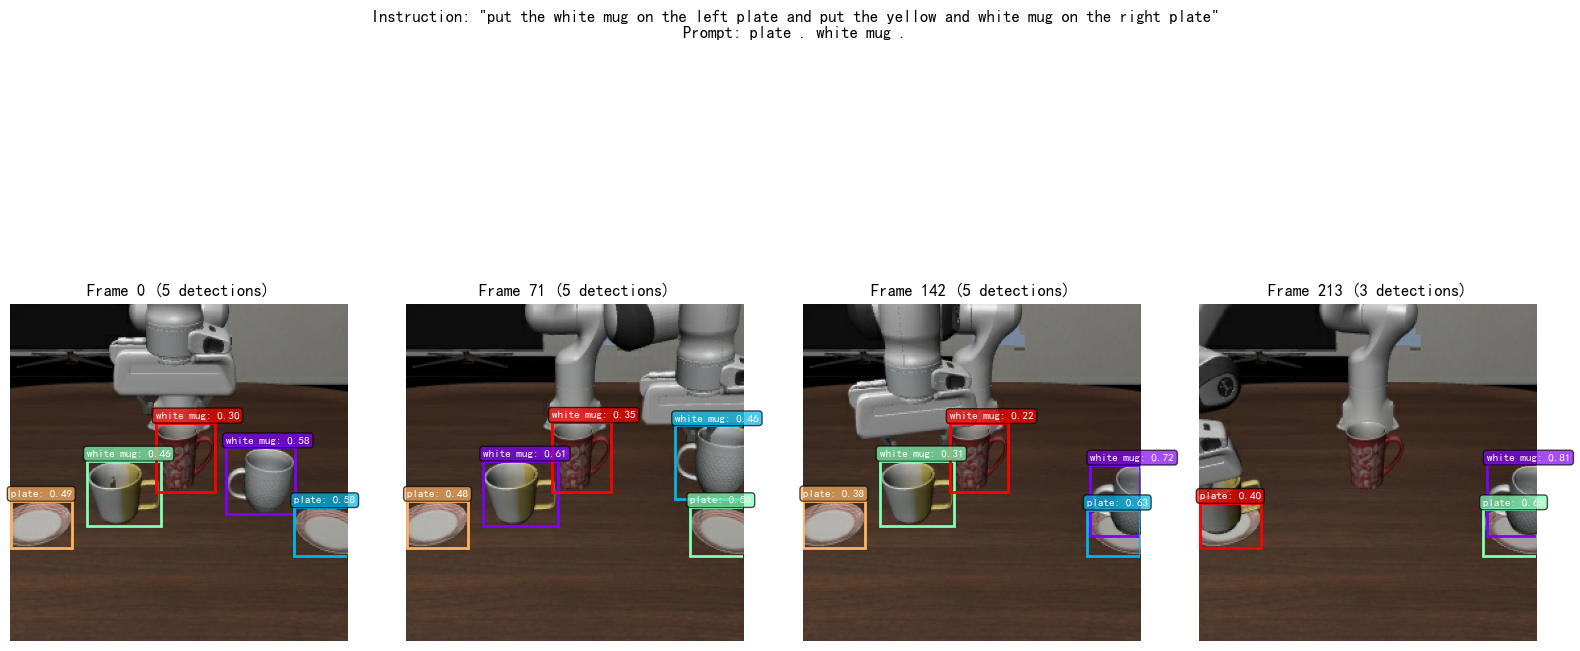

In [16]:
def visualize_detection_sequence(data, instruction, num_frames=4, figsize=(16, 8), is_raw=False):
    """可视化一个序列的多帧检测结果"""
    if is_raw:
        # 原始 TFRecord 格式 - data 是 JPEG 编码的图像列表
        total_frames = len(data)
    else:
        # tfds 格式 - data 是 steps 列表
        total_frames = len(data)
    
    num_frames = min(num_frames, total_frames)
    indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    # 提取物体
    objects = extract_objects_from_instruction(instruction)
    text_prompt = " . ".join(objects) + " ."
    
    n_cols = min(num_frames, 4)
    n_rows = (num_frames + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1)
    elif n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    axes = np.array(axes).flatten()
    
    fig.suptitle(f'Instruction: "{instruction}"\nPrompt: {text_prompt}', fontsize=12, y=1.05)
    
    for i, idx in enumerate(indices):
        if is_raw:
            # data 是列表，直接索引
            image = tf.io.decode_jpeg(data[idx], channels=3).numpy()
        else:
            image = data[idx]['observation']['image'].numpy()
        
        # 检测
        results = detect_objects(image, text_prompt, box_threshold=0.2, text_threshold=0.2)
        
        # 绘制
        axes[i].imshow(image)
        
        boxes = results["boxes"].cpu().numpy()
        scores = results["scores"].cpu().numpy()
        labels = results["labels"]
        
        colors_arr = plt.cm.rainbow(np.linspace(0, 1, max(len(boxes), 1)))
        
        for box, score, label, color in zip(boxes, scores, labels, colors_arr):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                fill=False, edgecolor=color, linewidth=2
            )
            axes[i].add_patch(rect)
            axes[i].text(x1, y1 - 3, f'{label}: {score:.2f}', 
                        color='white', fontsize=8,
                        bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
        
        axes[i].set_title(f'Frame {idx} ({len(boxes)} detections)')
        axes[i].axis('off')
    
    # 隐藏多余的子图
    for i in range(num_frames, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 对第一个 episode 进行序列检测可视化
if len(episodes) > 0:
    print("Episode 1 检测序列:")
    if use_raw_format:
        visualize_detection_sequence(images1, lang1, num_frames=4, is_raw=True)
    else:
        visualize_detection_sequence(steps1, lang1, num_frames=4, is_raw=False)
else:
    print("没有加载到 episodes，跳过序列检测可视化")


In [19]:
# 对第二个 episode 进行序列检测可视化
if len(episodes) > 1:
    print("Episode 2 检测序列:")
    if use_raw_format:
        visualize_detection_sequence(images2, lang2, num_frames=4, is_raw=True)
    else:
        visualize_detection_sequence(steps2, lang2, num_frames=4, is_raw=False)


Episode 2 检测序列:


NameError: name 'steps2' is not defined

## 7. 自定义检测测试


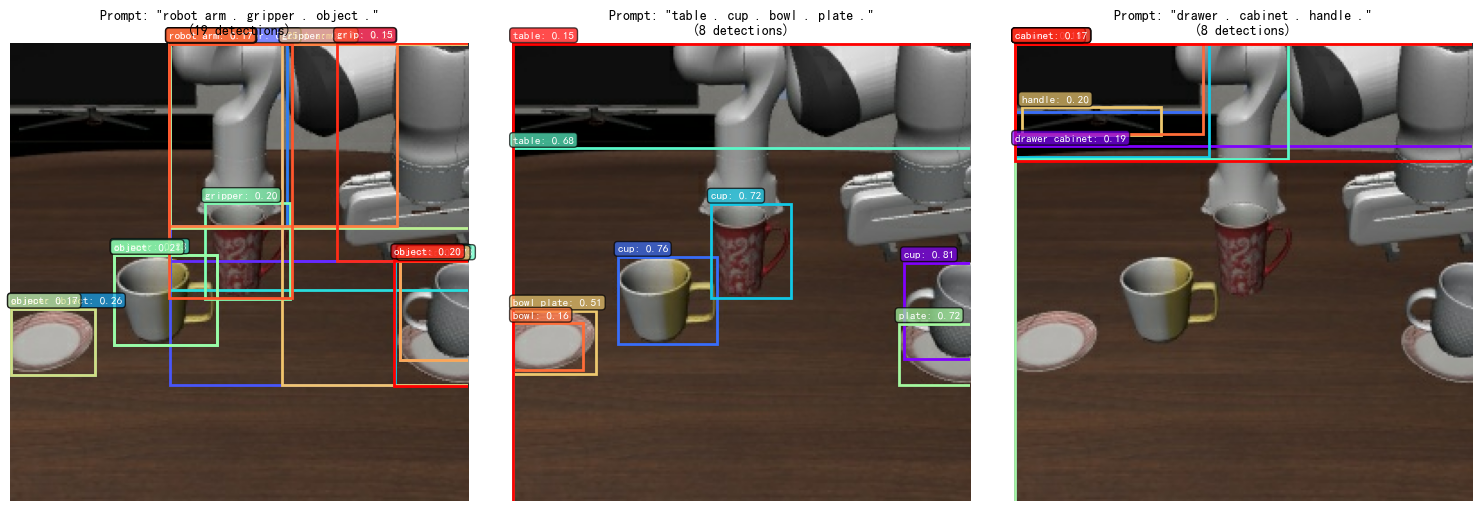

In [18]:
# 自定义 prompt 测试
# 可以修改下面的 prompt 来测试不同的检测效果

custom_prompts = [
    "robot arm . gripper . object .",
    "table . cup . bowl . plate .",
    "drawer . cabinet . handle ."
]

if len(episodes) > 0:
    # 获取测试图像
    if use_raw_format:
        images = episodes[0]['images']  # 列表形式
        test_image = tf.io.decode_jpeg(images[len(images) // 2], channels=3).numpy()
    else:
        test_image = steps1[len(steps1) // 2]['observation']['image'].numpy()
    
    fig, axes = plt.subplots(1, len(custom_prompts), figsize=(5 * len(custom_prompts), 5))
    
    for i, prompt in enumerate(custom_prompts):
        results = detect_objects(test_image, prompt, box_threshold=0.15, text_threshold=0.15)
        
        axes[i].imshow(test_image)
        
        boxes = results["boxes"].cpu().numpy()
        scores = results["scores"].cpu().numpy()
        labels = results["labels"]
        
        colors_arr = plt.cm.rainbow(np.linspace(0, 1, max(len(boxes), 1)))
        
        for box, score, label, color in zip(boxes, scores, labels, colors_arr):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor=color, linewidth=2)
            axes[i].add_patch(rect)
            axes[i].text(x1, y1-3, f'{label}: {score:.2f}', color='white', fontsize=8,
                        bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
        
        axes[i].set_title(f'Prompt: "{prompt}"\n({len(boxes)} detections)', fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("没有加载到 episodes，跳过自定义 prompt 测试")


开始全子集 Grounding DINO 检测评估

──────────────────────────────────────────────────
📦 评估子集: libero_spatial_no_noops
──────────────────────────────────────────────────


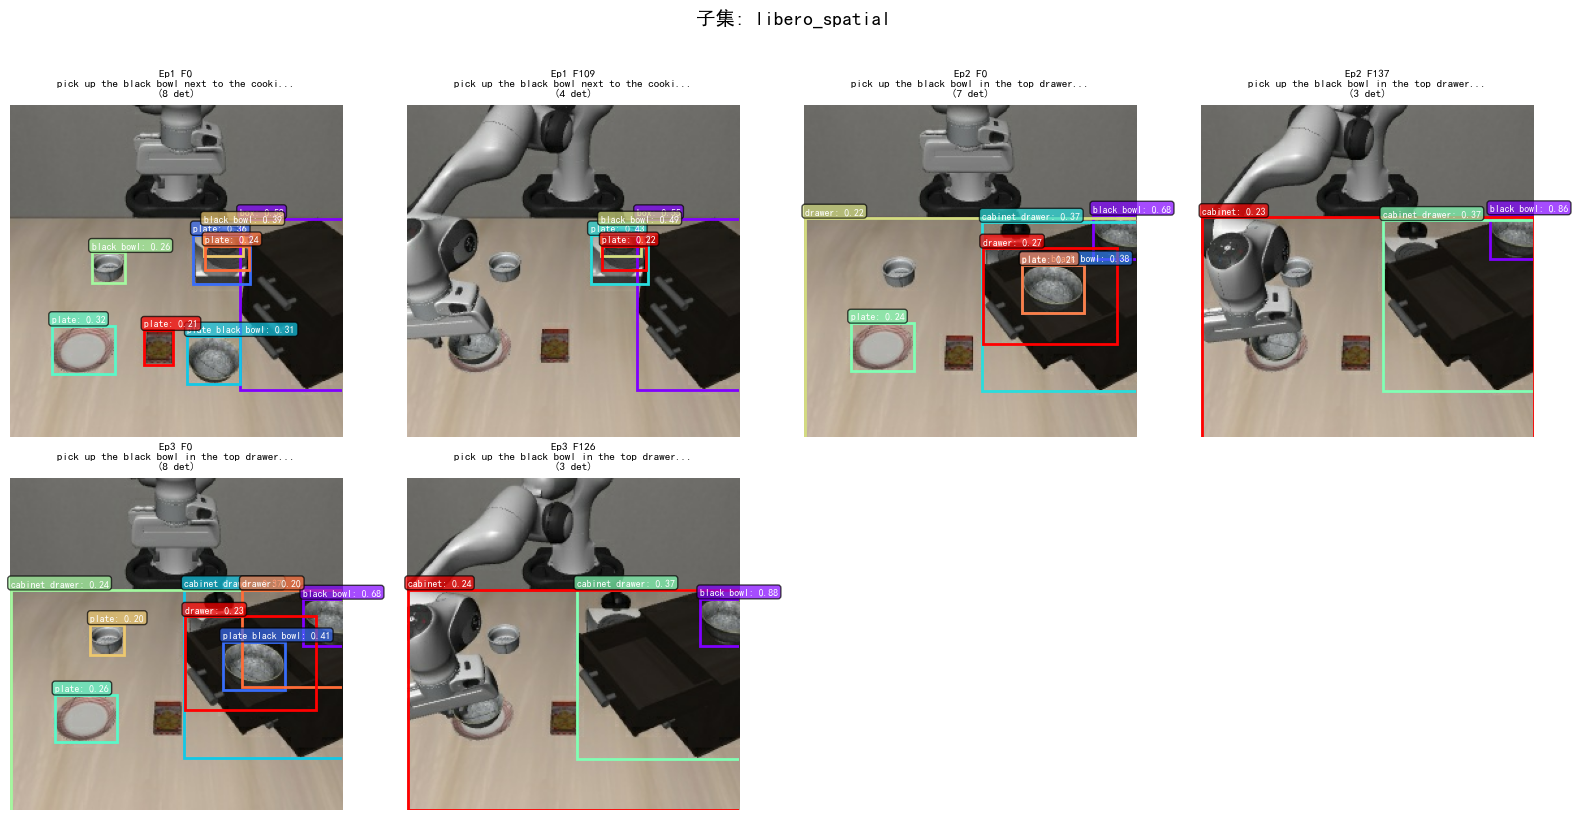


📊 评估结果:
   ├─ 评估 episodes: 3
   ├─ 总检测数: 33
   └─ 平均每帧检测数: 5.50

──────────────────────────────────────────────────
📦 评估子集: libero_object_no_noops
──────────────────────────────────────────────────


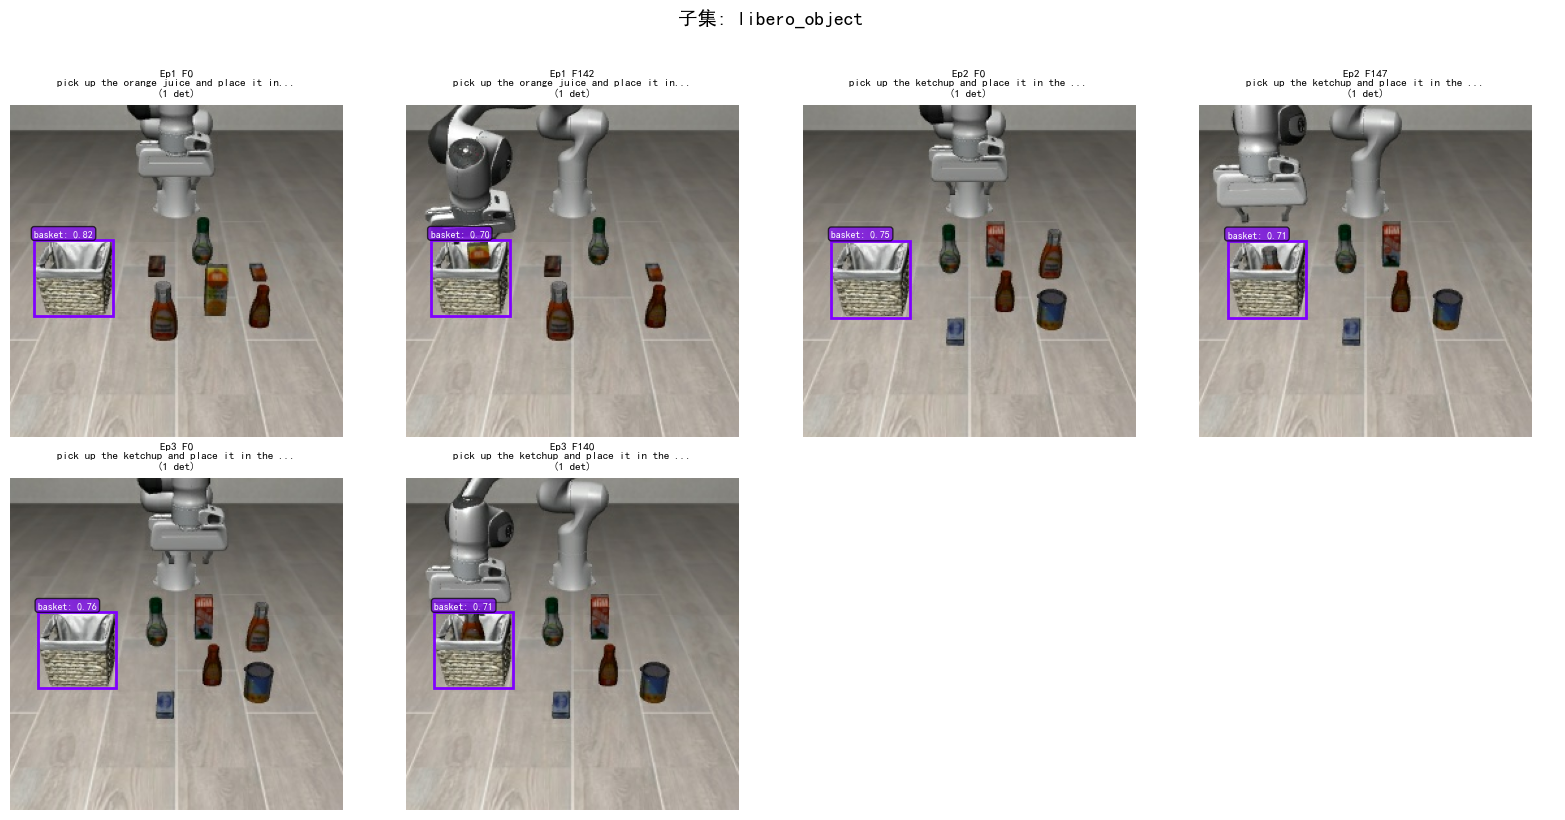


📊 评估结果:
   ├─ 评估 episodes: 3
   ├─ 总检测数: 6
   └─ 平均每帧检测数: 1.00

──────────────────────────────────────────────────
📦 评估子集: libero_goal_no_noops
──────────────────────────────────────────────────


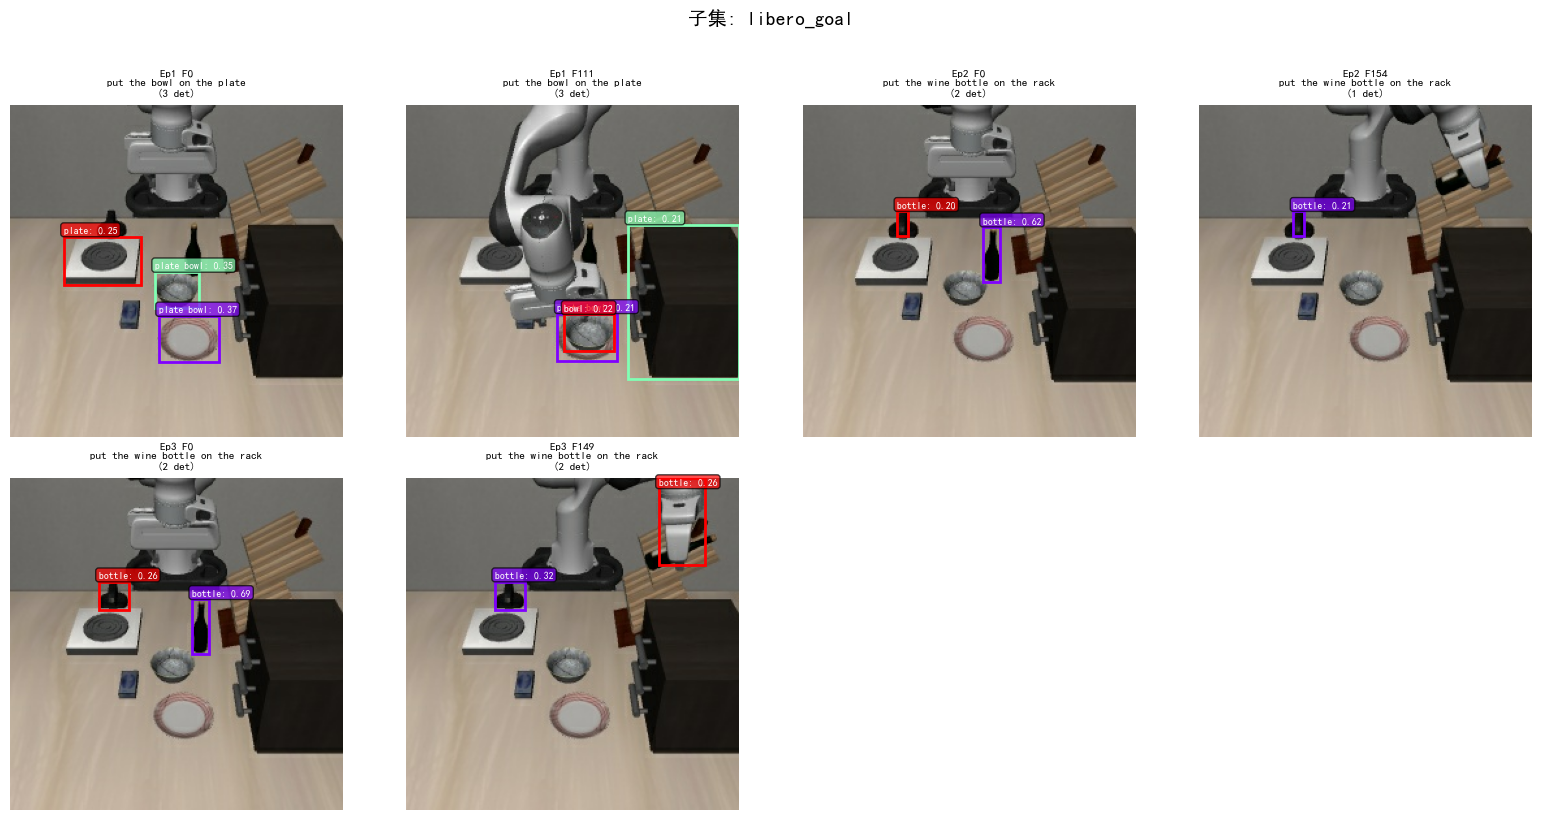


📊 评估结果:
   ├─ 评估 episodes: 3
   ├─ 总检测数: 13
   └─ 平均每帧检测数: 2.17

──────────────────────────────────────────────────
📦 评估子集: libero_10_no_noops
──────────────────────────────────────────────────


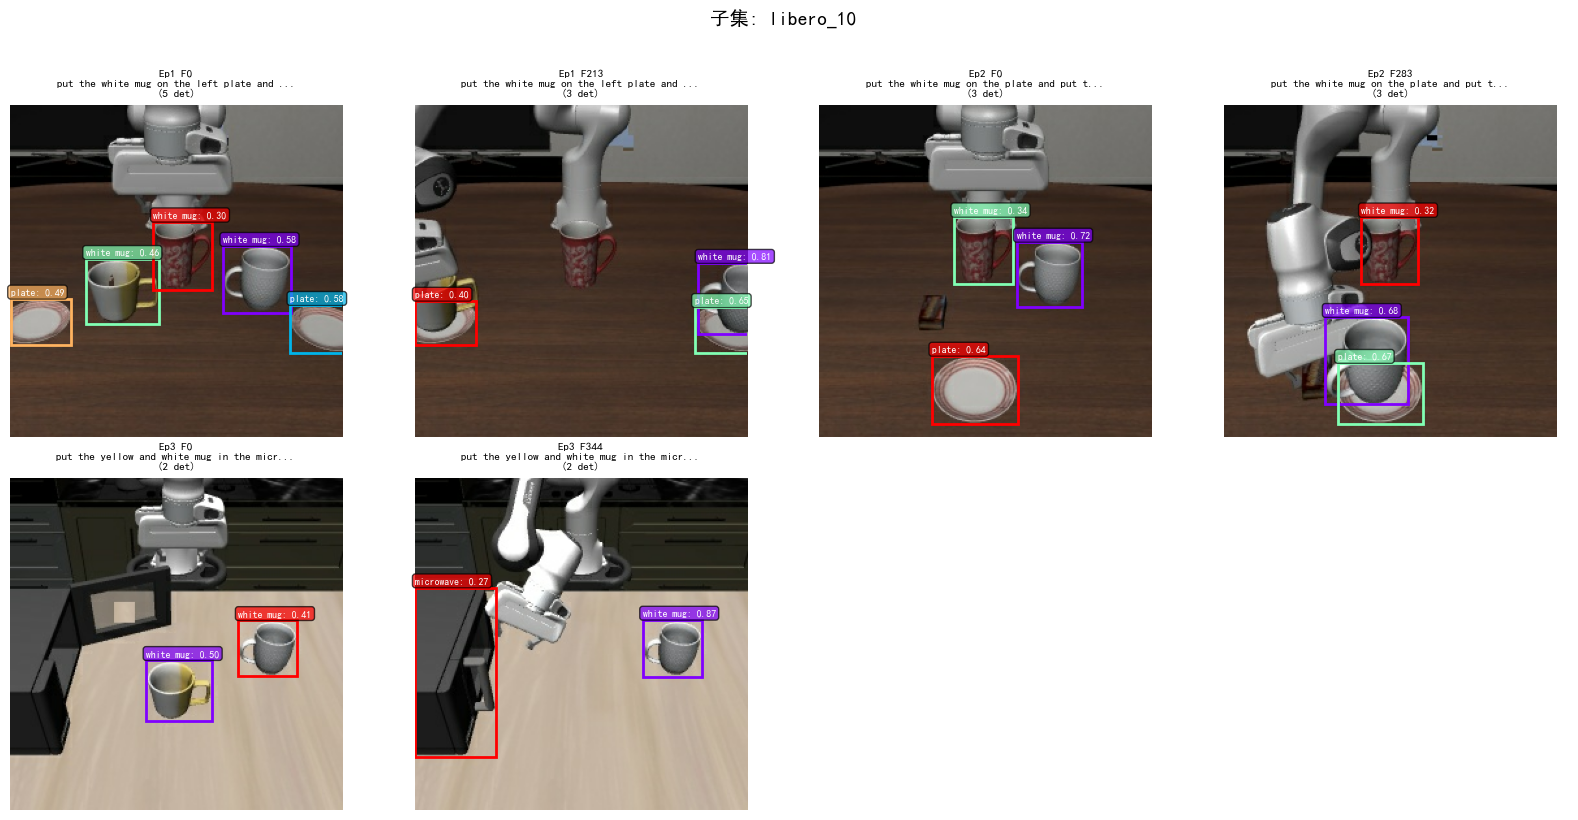


📊 评估结果:
   ├─ 评估 episodes: 3
   ├─ 总检测数: 18
   └─ 平均每帧检测数: 3.00


## 8. 总结

本 notebook 演示了：
1. 如何加载和可视化 LIBERO RLDS 数据集
2. 如何使用 HuggingFace 的 Grounding DINO 进行物体检测
3. 检测效果和阈值调整

### 下一步
- 运行 `extract_libero_images.py` 批量提取图像
- 运行 `generate_pseudo_labels.py` 生成伪标签
- 运行 `convert_to_coco.py` 转换为 COCO 格式
- 运行 `finetune_grounding_dino.py` 进行微调训练


In [ ]:
# 9.2 Stage 2: Grounding DINO 检测 + 绘图

@dataclass
class Detection:
    """检测结果"""
    label: str
    numbered_label: str
    box: Tuple[int, int, int, int]  # (x1, y1, x2, y2)
    score: float
    color: Tuple[int, int, int] = None
    color_name: str = ""

# 高对比度颜色
COLORS = [
    ((255, 0, 0), "红框"),
    ((0, 255, 0), "绿框"),
    ((0, 0, 255), "蓝框"),
    ((255, 255, 0), "黄框"),
    ((255, 0, 255), "紫框"),
    ((0, 255, 255), "青框"),
    ((255, 165, 0), "橙框"),
]

def detect_objects_pipeline(image, object_names, box_threshold=0.25, text_threshold=0.25):
    """使用 Grounding DINO 检测物体"""
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image)
    else:
        pil_image = image
    
    text_prompt = " . ".join(object_names) + " ."
    
    inputs = processor(images=pil_image, text=text_prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs["input_ids"],
        threshold=box_threshold,
        text_threshold=text_threshold,
        target_sizes=[pil_image.size[::-1]]
    )[0]
    
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"]
    
    # 按标签分组并添加序号
    label_groups = defaultdict(list)
    detections = []
    
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        det = Detection(
            label=label,
            numbered_label=label,
            box=(int(x1), int(y1), int(x2), int(y2)),
            score=float(score)
        )
        label_groups[label].append(det)
        detections.append(det)
    
    # 添加序号
    for label, group in label_groups.items():
        group.sort(key=lambda x: x.score, reverse=True)
        for idx, det in enumerate(group, start=1):
            if len(group) > 1:
                det.numbered_label = f"{label}_{idx}"
    
    # 分配颜色
    for i, det in enumerate(detections):
        color, color_name = COLORS[i % len(COLORS)]
        det.color = color
        det.color_name = color_name
    
    return detections

def draw_detections(image, detections):
    """在图像上绘制检测框"""
    from PIL import ImageDraw, ImageFont
    
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image).convert("RGB")
    else:
        pil_image = image.convert("RGB")
    
    annotated = pil_image.copy()
    draw = ImageDraw.Draw(annotated)
    
    try:
        font = ImageFont.truetype("arial.ttf", 14)
    except:
        font = ImageFont.load_default()
    
    for det in detections:
        x1, y1, x2, y2 = det.box
        color = det.color
        
        # 绘制边框
        for offset in range(3):
            draw.rectangle([x1-offset, y1-offset, x2+offset, y2+offset], outline=color)
        
        # 绘制标签
        label_text = det.numbered_label
        draw.rectangle([x1, max(0, y1-18), x1+len(label_text)*8+4, y1], fill=color)
        draw.text((x1+2, max(0, y1-16)), label_text, fill=(255, 255, 255), font=font)
    
    return annotated

def format_detections_text(detections, img_width, img_height):
    """生成检测结果文本"""
    lines = []
    for det in detections:
        x1, y1, x2, y2 = det.box
        norm_box = (
            int(x1 * 1000 / img_width),
            int(y1 * 1000 / img_height),
            int(x2 * 1000 / img_width),
            int(y2 * 1000 / img_height)
        )
        lines.append(f"- {det.color_name} {det.numbered_label}: ({norm_box[0]},{norm_box[1]},{norm_box[2]},{norm_box[3]}) [置信度: {det.score:.2f}]")
    return "\n".join(lines)

print("✓ Stage 2 模块加载完成")
